In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'model_values.xlsx'

# need to change to this file: "C:\Users\brend\Zen\Zen - Active Customers\Mitsui\MIT007_Solar-Battery Analysis\03 Communications\Aquamarine - 12x24 Production -_MBK Modeled_R2.xlsx"

plantPredict = pd.read_excel(filename, sheet_name='Script') #pd.read_excel(filename, sheet_name='Year 1', skiprows = 3, usecols = [0,1,2,3])
###pvGen_scaled is pvGen scaled from 250 to 300, but I have applied a factor on pvGenIn below. 
pvGen = plantPredict["pvGen"]

In [2]:
def elyBattDispatch(power,duration,maxElyP,pvGen, output_select=False):

    """ initial battery size estimate 
    based on assumption of 4%/yr degradation - conservative
    and 5 yr overbuild which is reasonable overbuild"""
    # power = 5
    # duration = 4
    # maxElyP = 3
    
    ### bolMWh is not called anywhere --- can we take this out?
    #bolMWh = power*duration/(1-0.04)**5
    
    battCap = power*duration
    CP = 1/duration
    
    """ Battery Efficiency estimate based on Samsung E3 """
    effBatt = 0.0236 * CP**2 - 0.0752 * CP + 0.9764
    effMVT = 0.99
    effAC = 0.99
    
    RTE = effMVT * effAC * effBatt * effMVT * effAC
    
    soc1 = np.zeros(8760)
    battP = np.zeros(8760)
    elyP = np.zeros(8760)
    elyP_batt = np.zeros(8760)
    chgP = np.zeros(8760)
    
    for i in range(1,8760):
        
        # electrolyzer dispatch
        if (pvGen[i] <= maxElyP) and (pvGen[i] > 0):
            
            elyP[i] = pvGen[i]
            
        elif pvGen[i] > maxElyP:
                
            elyP[i] = maxElyP       
        
        elif pvGen[i] <= 0:
                    
            elyP[i]  = 0
                    
                    
        # battery charging dispatch
       
        if (pvGen[i] - elyP[i]) > 0 and soc1[i-1] >= 0 and soc1[i-1] < battCap:
            
            
            if (soc1[i-1] + (pvGen[i] - elyP[i])) >= battCap:
                battP[i] = (battCap - soc1[i-1])*RTE
                chgP[i] = battP[i]
                
            elif (pvGen[i] - elyP[i]) > power:
                battP[i] = power * RTE
                chgP[i] = battP[i]
                
            elif (soc1[i-1] + (pvGen[i] - elyP[i])) < battCap:
                battP[i] = (pvGen[i] - elyP[i]) * RTE
                chgP[i] = battP[i]
                
                       
        # battery discharging dispatch - discharging is negative 
        if (pvGen[i] - elyP[i]) <= 0 and soc1[i-1] > 0 and soc1[i-1] <= battCap:
        
            if (soc1[i-1] - power) < 0 and elyP[i] < maxElyP and soc1[i-1] < maxElyP \
                and (soc1[i-1] + elyP[i]) < maxElyP:
                battP[i] = -soc1[i-1]
                elyP_batt[i] = abs(battP[i])
                    
            elif elyP[i] < maxElyP and (soc1[i-1] - (maxElyP - elyP[i])) > 0:
                battP[i] = -(maxElyP - elyP[i])
                elyP_batt[i] = abs(battP[i])
                
            elif elyP[i] < maxElyP and (soc1[i-1] - (maxElyP - elyP[i])) <= 0:
                battP[i] = -soc1[i-1]
                elyP_batt[i] = abs(battP[i])
                
        soc1[i] =  soc1[i-1] + battP[i]
            
               
    output = pd.DataFrame()       
    output['pv_gen'] = pd.DataFrame(pvGen)
    output['elyP'] = pd.DataFrame(elyP)
    output['battP'] = pd.DataFrame(battP)
    output['elyP_batt'] = pd.DataFrame(elyP_batt)
    output['datetime'] = pd.to_datetime(plantPredict.iloc[:,0])
    output['charge_p'] = chgP/RTE
    output['pv_excess'] = output['pv_gen'] - output['elyP'] - output['charge_p']
    output['SOC'] = pd.DataFrame(soc1)
    
    output['wkday'] = output['datetime'].dt.weekday
    output['month'] = output['datetime'].dt.month
    output['qrtr'] = output['datetime'].dt.quarter
    output['hours'] = output['datetime'].dt.hour

    capex_batt_mwh = {
        2:463, # based on Chirreon estimate
        4:409, # based on converting Chirreon to 4 hour estimate
        6:391, 
        8:382,
        10:376,
        12:373 }
    
    capex_capacity_kw = {
            25:1450, # based on https://www.seia.org/research-resources/solar-market-insight-report-2021-year-review
            50:1300,
            100:1000 }
    
    pvCapacitySet = max(pvGen)

    if pvCapacitySet > 100:
        capex_kw = capex_capacity_kw[100]
    elif pvCapacitySet < 100 and pvCapacitySet > 50:
        capex_kw = capex_capacity_kw[50]
    else:
        capex_kw = capex_capacity_kw[25]
        
    
    # 0.12 capital recovery factor
    # annual opex = 3% capex
    ttlcapex = ( (pvCapacitySet * (capex_kw ) * 1000  ) + ( power * duration * (capex_batt_mwh[duration] * 1000) ) )
    lcoe = ttlcapex * (0.12 + 0.03) / (sum(elyP)+sum(elyP_batt)+sum(output['pv_excess']))
        
    #### if user does not specify that they want graphs out, does not output. Computationally heavy.
    if output_select is False:
        return sum(elyP)+sum(elyP_batt), sum(output['pv_excess']), ttlcapex, lcoe
    else:
        monthly = output.groupby(['month','hours'])
        monthly = monthly.battP.mean()
        for y in range(1, 13):
            ax = monthly[y].plot()
            ax.legend(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],loc='center left')
            ax.set_ylabel('MW')

            # y=5
            # monthly[y]
        return sum(elyP)+sum(elyP_batt), sum(output['pv_excess']), ttlcapex, lcoe, output, ax
    

In [3]:
def create_data_table(bess_power_of_solar, battDuration):

    table_width = len(battDuration) * 5
    table_height = len(bess_power_of_solar)

    df = pd.DataFrame(np.zeros([table_height, table_width]),
                    index=pd.Index(bess_power_of_solar, name='BESS Power [MW]:'),
                    columns=pd.MultiIndex.from_product([['Electrolyzer Energy [MWh]', 'Excess PV Energy [MWh]', 'Electrolyzer Utilization [MWh]', 'Total CapEx [$]','LCOE [$/MWh]'],battDuration], names=['', 'Hours:']))
    df.style
    return df

In [4]:
### Calls the elyBattDispatch function to get values, and retrieves the electrolyzer and excess_pv_energy values. 
### Appends values to a list to pump into table DF template
def electrolyzer_analysis(battPower, battDuration, P_ely, pvGenIn, output_select=False):
      electrolyzer_energy_list = []
      excess_pv_list = []
      ttl_capex_list =[]
      lcoe_list = []
      output_list = []
      axes_list = []
      if output_select:
            for battery_power in battPower: 
                  elecEnergy = []
                  excessPV = []
                  lcoes = []
                  ttl = []
                  outputs = []
                  axes = []
                  for duration in battDuration:
                        electrolyzer_energy, excess_pv_energy, ttlcapex, lcoe, output, ax = elyBattDispatch(battery_power,duration,P_ely,pvGenIn, output_select)
                        elecEnergy.append(electrolyzer_energy)
                        excessPV.append(excess_pv_energy)
                        ttl.append(ttlcapex)
                        lcoes.append(lcoe)
                        outputs.append(output)
                        axes.append(ax)

                  electrolyzer_energy_list.append(elecEnergy)
                  excess_pv_list.append(excessPV)
                  ttl_capex_list.append(ttl)
                  lcoe_list.append(lcoes)
                  output_list.append(outputs)
                  axes_list.append(axes)

            return electrolyzer_energy_list, excess_pv_list, ttl_capex_list, lcoe_list, output_list, axes_list
      else:
            for battery_power in battPower: 
                  elecEnergy = []
                  excessPV = []
                  lcoes = []
                  ttl = []
                  for duration in battDuration:
                        electrolyzer_energy, excess_pv_energy = elyBattDispatch(battery_power,duration,P_ely,pvGenIn)
                        elecEnergy.append(electrolyzer_energy)
                        excessPV.append(excess_pv_energy)
                        ttl.append(ttlcapex)
                        lcoes.append(lcoe)

                  electrolyzer_energy_list.append(elecEnergy)
                  excess_pv_list.append(excessPV)
                  ttl_capex_list.append(ttl)
                  lcoe_list.append(lcoes)

            return electrolyzer_energy_list, excess_pv_list, ttl_capex_list, lcoe_list

In [5]:
### Populate table with calculated values, and then calculate the utilization and LCOE
### Create function of below. 
def populate_dataframe(bess_power_of_solar, electrolyzer_energy_list, excess_pv_list, ttl_capex_list, lcoe_list, P_ely, pvCapacitySet, battDuration, df):
    i = 0
    
    for battery_power in bess_power_of_solar:
        df.loc[battery_power, "Electrolyzer Energy [MWh]"] = electrolyzer_energy_list[i]
        df.loc[battery_power, "Excess PV Energy [MWh]"] = excess_pv_list[i]
        elec_util_list = [x / ( P_ely * 8760) for x in electrolyzer_energy_list[i]]
        df.loc[battery_power, 'Electrolyzer Utilization [MWh]'] = elec_util_list
        df.loc[battery_power, 'Total CapEx [$]'] = ttl_capex_list[i]
        df.loc[battery_power, "LCOE [$/MWh]"] = lcoe_list[i]
        i += 1
        
    return df


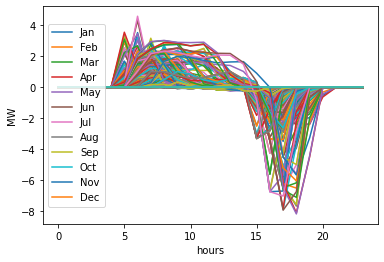

In [6]:
### Comprehensive function 
def ely_scenarios(ely_p_scenarios, battDuration, pvGenIn, bess_pcnt_solar, pvCapacitySet, output_select):
    excel_sheets =[]
    outputs = []
    axes = []
    
    if output_select:
         for scenario in ely_p_scenarios:
            P_ely = scenario
            bess_power_of_solar = bess_pcnt_solar * P_ely
            battPower = bess_pcnt_solar * P_ely
            ### Create the data table -> calculate the scenario and return electrolyzer energy and excess pv in lists + outputs and axes -> populate the created table with the calculated values
            df = create_data_table(bess_power_of_solar, battDuration)
            electrolyzer_energy_list, excess_pv_list, ttl_capex_list, lcoe_list, output, ax = electrolyzer_analysis(battPower, battDuration, P_ely, pvGenIn, output_select)
            df = populate_dataframe(bess_power_of_solar, electrolyzer_energy_list, excess_pv_list, ttl_capex_list, lcoe_list, P_ely, pvCapacitySet, battDuration, df)
            
            ### Append df, outputs and axes to list. df list used for writing after all scenarios are calculated
            excel_sheets.append(df)         
            outputs.append(output)
            axes.append(ax)
    else:
            for scenario in ely_p_scenarios:
                P_ely = scenario
                battPower = bess_pcnt_solar * P_ely
                bess_power_of_solar = bess_pcnt_solar * P_ely
                ### Create the data table -> calculate the scenario and return electrolyzer energy and excess pv in lists -> populate the created table with the calculated values
                df = create_data_table(bess_power_of_solar, battDuration)                             
                electrolyzer_energy_list, excess_pv_list, ttl_capex_list, lcoe_list = electrolyzer_analysis(battPower, battDuration, P_ely, pvGenIn)
                df = populate_dataframe(battPower, electrolyzer_energy_list, excess_pv_list, ttl_capex_list, lcoe_list, P_ely, pvCapacitySet, battDuration, df)
                ### Append df to list for writing after all scenarios are calculated
                excel_sheets.append(df) 

    ### write df's from list to excel workbook in different sheets
    with pd.ExcelWriter('model_output_scenarios.xlsx') as writer:
        i = 0
        for df in excel_sheets:
            df.to_excel(writer, sheet_name=f"{ely_p_scenarios[i]} MW")
            i += 1
       
    if not outputs:
        return excel_sheets
    else:
        return excel_sheets, outputs, axes
                 
### Edit scenarios here - ely_scenarios will run thorugh the analysis for each ELY MW value and battery duration value. Define your battery durations and electrolyzer MW values here: 
ely_p_scenarios = [2.4, 8.5, 12.1, 12] ### in MW
battDuration = [2, 4, 6] ### in hours
### Scale pvGenIn here. Base max pvGen is 250MW
pvCapacity = 250
pvCapacitySet = 12
pvGenIn =  (pvCapacitySet / pvCapacity) * pvGen 
## Check ~~~~ np.array is in percent
#battPower = np.array([0.25,0.5,1,1.5,2]) * P_ely
bess_pcnt_solar = np.array([0.05,0.1,0.2,0.3,0.4])
outputs = None

#run below if just want calculation and tables, run blocked out code for full outputs and axes - takes longer
#sheets = ely_scenarios(ely_p_scenarios, battDuration, pvGenIn, bess_pcnt_solar, pvCapacitySet, output_select=False)
sheets, outputs, axes = ely_scenarios(ely_p_scenarios, battDuration, pvGenIn, bess_pcnt_solar, pvCapacitySet, output_select=True)

## Plot Graphs from Outputs

### battP Graphs

In [7]:
if outputs:
    i = 0
    for scenario in outputs:
        j=0
        battPower = bess_pcnt_solar * ely_p_scenarios[i]
        for power in battPower:
            k=0
            for duration in battDuration:
                monthly = outputs[i][j][k].groupby(['month','hours'])
                monthly = monthly.battP.mean()
                for y in range(1, 13):
                    ax = monthly[y].plot()
                ax.legend(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],loc='center left')
                ax.set_ylabel('Battery Power (MW)')
                ax.set_xlabel('Time of Day (24-hr)')
                plt.title(str(ely_p_scenarios[i]) + 'MW ELY - ' + str(battPower[j]) + 'MW BattPwr - ' + str(battDuration[k]) + 'Hr')
                plt.savefig('./figures/scenarios/battP/'+ str(ely_p_scenarios[i]) + 'ely-' + str(battPower[j]) + 'mwBattPwr-' + str(battDuration[k]) + '-hr.png')
                plt.clf()
                k += 1
            
            j += 1
        
        i+= 1

<Figure size 432x288 with 0 Axes>

### elyP Graphs

In [8]:
if outputs:
    i = 0
    for scenario in outputs:
        j=0
        battPower = bess_pcnt_solar * ely_p_scenarios[i]
        for power in battPower:
            k=0
            for duration in battDuration:
                monthly = outputs[i][j][k].groupby(['month','hours'])
                monthly = monthly.elyP.mean()
                for y in range(1, 13):
                    ax = monthly[y].plot()
                ax.legend(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],loc='center left')
                ax.set_ylabel('Electrolyzer Power (MW)')
                ax.set_xlabel('Time of Day (24-hr)')
                plt.title(str(ely_p_scenarios[i]) + 'MW ELY - ' + str(battPower[j]) + 'MW BattPwr - ' + str(battDuration[k]) + 'Hr')
                plt.savefig('./figures/scenarios/elyP/'+ str(ely_p_scenarios[i]) + 'ely-' + str(battPower[j]) + 'mwBattPwr-' + str(battDuration[k]) + '-hr.png')
                plt.clf()
                k += 1
            
            j += 1
        
        i+= 1

<Figure size 432x288 with 0 Axes>

### pv_excess Graphs

In [9]:
if outputs:
    i = 0
    for scenario in outputs:
        j=0
        battPower = bess_pcnt_solar * ely_p_scenarios[i]
        for power in battPower:
            k=0
            for duration in battDuration:
                monthly = outputs[i][j][k].groupby(['month','hours'])
                monthly = monthly.pv_excess.mean()
                for y in range(1, 13):
                    ax = monthly[y].plot()
                ax.legend(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],loc='center left')
                ax.set_ylabel('PV Excess (MW)')
                ax.set_xlabel('Time of Day (24-hr)')
                plt.title(str(ely_p_scenarios[i]) + 'MW ELY - ' + str(battPower[j]) + 'MW BattPwr - ' + str(battDuration[k]) + 'Hr')
                plt.savefig('./figures/scenarios/pv_excess/'+ str(ely_p_scenarios[i]) + 'ely-' + str(battPower[j]) + 'mwBattPwr-' + str(battDuration[k]) + '-hr.png')
                plt.clf()
                k += 1
            
            j += 1
        
        i+= 1

<Figure size 432x288 with 0 Axes>

### pv_gen Graph

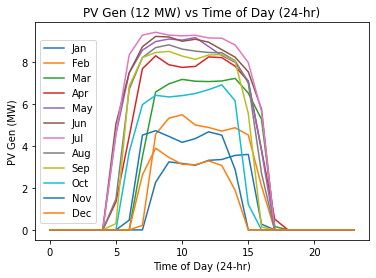

<Figure size 432x288 with 0 Axes>

In [10]:
if outputs:
    monthly = outputs[0][0][0].groupby(['month','hours'])
    monthly = monthly.pv_excess.mean()
    for y in range(1, 13):
        ax = monthly[y].plot()
    ax.legend(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],loc='center left')
    ax.set_ylabel('PV Gen (MW)')
    ax.set_xlabel('Time of Day (24-hr)')
    plt.title('PV Gen (' + str(pvCapacitySet) + ' MW) vs Time of Day (24-hr)')
    plt.savefig('./figures/scenarios/pv_gen/pv_gen_'+ str(pvCapacitySet) +'mw.png')
    plt.show()
    plt.clf()

## Exploratory Analysis

In [11]:
###Create cumulative Dataframes for each MW Scenario. 
if outputs:
    excel_sheets = []
    i = 0

    for scenario in outputs:
        j=0
        frame = np.zeros([1,13])
        df=pd.DataFrame(data=frame, columns=['scenario', 'pv_gen','elyP','battP', 'elyP_batt', 'datetime', 'charge_p', 'pv_excess', 'SOC', 'wkday','month', 'qrtr','hours'])
        for power in battPower:
            k=0
            for duration in battDuration:
                scenario =  outputs[i][j][k]
                scenario_df = pd.DataFrame(scenario)
                scenario_df['scenario'] = str(ely_p_scenarios[i]) + 'ely-' + str(battPower[j]) + 'mwBattPwr-' + str(battDuration[k]) + '-hr'
                df = pd.concat([df,scenario_df])
                k += 1
            
            j += 1
        excel_sheets.append(df)
        i+= 1

In [12]:
### Write to Excel - 1mil rows and takes 3 mins

# with pd.ExcelWriter('full_scenarios.xlsx') as writer:
#         i = 0
#         for df in excel_sheets:
#             df.to_excel(writer, sheet_name=f"{ely_p_scenarios[i]} MW")
#             i += 1

### Basic Stats On Each MW Scenario (3, 6, 9, 12)

In [13]:
for sheet in excel_sheets:
    sheet.drop(sheet[sheet['scenario']==0].index, inplace=True)

df_mw1 = excel_sheets[0]
df_mw2 = excel_sheets[1]
df_mw3 = excel_sheets[2]
df_mw4 = excel_sheets[3]
df_mw1.describe()

,pv_gen,elyP,battP,elyP_batt,charge_p,pv_excess,SOC,wkday,month,qrtr,hours
count,131385.000000,131385.000000,1.313850e+05,131385.000000,1.313850e+05,1.313850e+05,131385.000000,131385.000000,131385.000000,131385.000000,131385.000000
mean,3.807355,1.066020,0.000000e+00,0.080392,8.724305e-02,2.654092e+00,0.811351,3.005366,6.525745,2.509533,11.499829
std,4.758503,1.153138,5.603859e-01,0.353155,4.547491e-01,3.707383e+00,1.359345,2.000143,3.447165,1.116618,6.920445
min,0.000000,0.000000,-2.400000e+00,0.000000,0.000000e+00,-1.110223e-16,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,4.000000,2.000000,6.000000
50%,0.062649,0.062649,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,3.000000,7.000000,3.000000,11.000000
75%,9.016949,2.400000,8.416186e-07,0.000000,9.135282e-07,6.392191e+00,0.960000,5.000000,10.000000,4.000000,17.000000
max,12.000000,2.400000,5.336733e+00,2.400000,5.760000e+00,9.600000e+00,5.760000,6.000000,12.000000,4.000000,23.000000


In [14]:
df_mw2.describe()

,pv_gen,elyP,battP,elyP_batt,charge_p,pv_excess,SOC,wkday,month,qrtr,hours
count,131385.000000,131385.000000,1.313850e+05,131385.000000,1.313850e+05,1.313850e+05,131385.000000,131385.000000,131385.000000,131385.000000,131385.000000
mean,3.807355,3.183646,0.000000e+00,0.190352,2.066430e-01,4.170666e-01,1.450506,3.005366,6.525745,2.509533,11.499829
std,4.758503,3.831684,1.145006e+00,0.955197,6.196776e-01,9.607777e-01,3.229647,2.000143,3.447165,1.116618,6.920445
min,0.000000,0.000000,-8.500000e+00,0.000000,0.000000e+00,-4.440892e-16,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,4.000000,2.000000,6.000000
50%,0.062649,0.062649,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,3.000000,7.000000,3.000000,11.000000
75%,9.016949,8.500000,1.235264e-07,0.000000,1.361209e-07,0.000000e+00,1.249345,5.000000,10.000000,4.000000,17.000000
max,12.000000,8.500000,3.230776e+00,8.500000,3.492706e+00,3.500000e+00,20.399998,6.000000,12.000000,4.000000,23.000000


In [15]:
df_mw3.describe()

,pv_gen,elyP,battP,elyP_batt,charge_p,pv_excess,SOC,wkday,month,qrtr,hours
count,131385.000000,131385.000000,131385.0,131385.0,131385.0,131385.0,131385.0,131385.000000,131385.000000,131385.000000,131385.000000
mean,3.807355,3.807355,0.0,0.0,0.0,0.0,0.0,3.005366,6.525745,2.509533,11.499829
std,4.758503,4.758503,0.0,0.0,0.0,0.0,0.0,2.000143,3.447165,1.116618,6.920445
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,2.000000,6.000000
50%,0.062649,0.062649,0.0,0.0,0.0,0.0,0.0,3.000000,7.000000,3.000000,11.000000
75%,9.016949,9.016949,0.0,0.0,0.0,0.0,0.0,5.000000,10.000000,4.000000,17.000000
max,12.000000,12.000000,0.0,0.0,0.0,0.0,0.0,6.000000,12.000000,4.000000,23.000000


In [16]:
df_mw4.describe()

,pv_gen,elyP,battP,elyP_batt,charge_p,pv_excess,SOC,wkday,month,qrtr,hours
count,131385.000000,131385.000000,131385.0,131385.0,131385.0,131385.0,131385.0,131385.000000,131385.000000,131385.000000,131385.000000
mean,3.807355,3.807355,0.0,0.0,0.0,0.0,0.0,3.005366,6.525745,2.509533,11.499829
std,4.758503,4.758503,0.0,0.0,0.0,0.0,0.0,2.000143,3.447165,1.116618,6.920445
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,2.000000,6.000000
50%,0.062649,0.062649,0.0,0.0,0.0,0.0,0.0,3.000000,7.000000,3.000000,11.000000
75%,9.016949,9.016949,0.0,0.0,0.0,0.0,0.0,5.000000,10.000000,4.000000,17.000000
max,12.000000,12.000000,0.0,0.0,0.0,0.0,0.0,6.000000,12.000000,4.000000,23.000000


### Breakdown of Mean and Sum of Each Category for Each Scenario

In [17]:
df_mw1_scenarios =  df_mw1.loc[:, 'scenario':'SOC'].groupby('scenario')
df_mw1_scenarios.agg(['mean','sum'])

C:\Users\TYLERD~1\AppData\Local\Temp/ipykernel_17404/2281652373.py:2: FutureWarning: ['datetime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_mw1_scenarios.agg(['mean','sum'])


pv_gen                   elyP  \
                                             mean           sum     mean   
scenario                                                                   
2.4ely-0.6000000000000001mwBattPwr-2-hr  3.807355  33348.626505  1.06602   
2.4ely-0.6000000000000001mwBattPwr-4-hr  3.807355  33348.626505  1.06602   
2.4ely-0.6000000000000001mwBattPwr-6-hr  3.807355  33348.626505  1.06602   
2.4ely-1.2000000000000002mwBattPwr-2-hr  3.807355  33348.626505  1.06602   
2.4ely-1.2000000000000002mwBattPwr-4-hr  3.807355  33348.626505  1.06602   
2.4ely-1.2000000000000002mwBattPwr-6-hr  3.807355  33348.626505  1.06602   
2.4ely-2.4000000000000004mwBattPwr-2-hr  3.807355  33348.626505  1.06602   
2.4ely-2.4000000000000004mwBattPwr-4-hr  3.807355  33348.626505  1.06602   
2.4ely-2.4000000000000004mwBattPwr-6-hr  3.807355  33348.626505  1.06602   
2.4ely-3.5999999999999996mwBattPwr-2-hr  3.807355  33348.626505  1.06602   
2.4ely-3.5999999999999996mwBattPwr-4-hr  3.807355  33348.626505  1.06602   
2.4ely-3.5999999999999996mwBattPwr-6-hr  3.807355  33348.626505  1.06602   
2.4ely-4.800000000000001mwBattPwr-2-hr   3.807355  33348.626505  1.06602   
2.4ely-4.800000000000001mwBattPwr-4-hr   3.807355  33348.626505  1.06602   
2.4ely-4.800000000000001mwBattPwr-6-hr   3.807355  33348.626505  1.06602   

                                                             battP  \
                                                 sum          mean   
scenario                                                             
2.4ely-0.6000000000000001mwBattPwr-2-hr  9337.273006  7.922016e-19   
2.4ely-0.6000000000000001mwBattPwr-4-hr  9337.273006 -8.872658e-19   
2.4ely-0.6000000000000001mwBattPwr-6-hr  9337.273006 -2.560396e-18   
2.4ely-1.2000000000000002mwBattPwr-2-hr  9337.273006  1.793544e-18   
2.4ely-1.2000000000000002mwBattPwr-4-hr  9337.273006 -1.495677e-18   
2.4ely-1.2000000000000002mwBattPwr-6-hr  9337.273006 -6.236211e-18   
2.4ely-2.4000000000000004mwBattPwr-2-hr  9337.273006  3.663140e-18   
2.4ely-2.4000000000000004mwBattPwr-4-hr  9337.273006 -2.002686e-18   
2.4ely-2.4000000000000004mwBattPwr-6-hr  9337.273006 -1.424695e-17   
2.4ely-3.5999999999999996mwBattPwr-2-hr  9337.273006 -5.070090e-20   
2.4ely-3.5999999999999996mwBattPwr-4-hr  9337.273006 -1.320759e-17   
2.4ely-3.5999999999999996mwBattPwr-6-hr  9337.273006  2.185209e-17   
2.4ely-4.800000000000001mwBattPwr-2-hr   9337.273006  7.503734e-18   
2.4ely-4.800000000000001mwBattPwr-4-hr   9337.273006 -2.966003e-18   
2.4ely-4.800000000000001mwBattPwr-6-hr   9337.273006 -3.249928e-17   

                                                      elyP_batt               \
                                                  sum      mean          sum   
scenario                                                                       
2.4ely-0.6000000000000001mwBattPwr-2-hr  6.938894e-15  0.010023    87.793264   
2.4ely-0.6000000000000001mwBattPwr-4-hr -7.771561e-15  0.019806   173.479507   
2.4ely-0.6000000000000001mwBattPwr-6-hr -2.242651e-14  0.029390   257.424514   
2.4ely-1.2000000000000002mwBattPwr-2-hr  1.570966e-14  0.019870   174.045535   
2.4ely-1.2000000000000002mwBattPwr-4-hr -1.310063e-14  0.039159   342.993298   
2.4ely-1.2000000000000002mwBattPwr-6-hr -5.462297e-14  0.058041   508.383899   
2.4ely-2.4000000000000004mwBattPwr-2-hr  3.208545e-14  0.039323   344.431946   
2.4ely-2.4000000000000004mwBattPwr-4-hr -1.754152e-14  0.077070   675.054769   
2.4ely-2.4000000000000004mwBattPwr-6-hr -1.247891e-13  0.114569  1003.513288   
2.4ely-3.5999999999999996mwBattPwr-2-hr -4.440892e-16  0.058453   511.989251   
2.4ely-3.5999999999999996mwBattPwr-4-hr -1.156852e-13  0.114864  1006.089973   
2.4ely-3.5999999999999996mwBattPwr-6-hr  1.914024e-13  0.170765  1495.726687   
2.4ely-4.800000000000001mwBattPwr-2-hr   6.572520e-14  0.077388   677.845525   
2.4ely-4.800000000000001mwBattPwr-4-hr  -2.597922e-14  0.152712  1337.604636   
2.4ely-4.800000000000001mwBattPwr-6-hr  -2.846612e-13

In [18]:
df_mw2_scenarios =  df_6mw.loc[:, 'scenario':'SOC'].groupby('scenario')
df_mw2_scenarios.agg(['mean','sum'])

NameError: name 'df_6mw' is not defined

In [ ]:
df_mw3_scenarios =  df_mw3.loc[:, 'scenario':'SOC'].groupby('scenario')
df_mw3_scenarios.agg(['mean','sum'])

C:\Users\TYLERD~1\AppData\Local\Temp/ipykernel_16176/3107022995.py:2: FutureWarning: ['datetime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_mw3_scenarios.agg(['mean','sum'])


pv_gen                    elyP  \
                                              mean           sum      mean   
scenario                                                                     
12.1ely-0.6000000000000001mwBattPwr-2-hr  3.807355  33348.626505  3.807355   
12.1ely-0.6000000000000001mwBattPwr-4-hr  3.807355  33348.626505  3.807355   
12.1ely-0.6000000000000001mwBattPwr-6-hr  3.807355  33348.626505  3.807355   
12.1ely-1.2000000000000002mwBattPwr-2-hr  3.807355  33348.626505  3.807355   
12.1ely-1.2000000000000002mwBattPwr-4-hr  3.807355  33348.626505  3.807355   
12.1ely-1.2000000000000002mwBattPwr-6-hr  3.807355  33348.626505  3.807355   
12.1ely-2.4000000000000004mwBattPwr-2-hr  3.807355  33348.626505  3.807355   
12.1ely-2.4000000000000004mwBattPwr-4-hr  3.807355  33348.626505  3.807355   
12.1ely-2.4000000000000004mwBattPwr-6-hr  3.807355  33348.626505  3.807355   
12.1ely-3.5999999999999996mwBattPwr-2-hr  3.807355  33348.626505  3.807355   
12.1ely-3.5999999999999996mwBattPwr-4-hr  3.807355  33348.626505  3.807355   
12.1ely-3.5999999999999996mwBattPwr-6-hr  3.807355  33348.626505  3.807355   
12.1ely-4.800000000000001mwBattPwr-2-hr   3.807355  33348.626505  3.807355   
12.1ely-4.800000000000001mwBattPwr-4-hr   3.807355  33348.626505  3.807355   
12.1ely-4.800000000000001mwBattPwr-6-hr   3.807355  33348.626505  3.807355   

                                                       battP      elyP_batt  \
                                                   sum  mean  sum      mean   
scenario                                                                      
12.1ely-0.6000000000000001mwBattPwr-2-hr  33348.626505   0.0  0.0       0.0   
12.1ely-0.6000000000000001mwBattPwr-4-hr  33348.626505   0.0  0.0       0.0   
12.1ely-0.6000000000000001mwBattPwr-6-hr  33348.626505   0.0  0.0       0.0   
12.1ely-1.2000000000000002mwBattPwr-2-hr  33348.626505   0.0  0.0       0.0   
12.1ely-1.2000000000000002mwBattPwr-4-hr  33348.626505   0.0  0.0       0.0   
12.1ely-1.2000000000000002mwBattPwr-6-hr  33348.626505   0.0  0.0       0.0   
12.1ely-2.4000000000000004mwBattPwr-2-hr  33348.626505   0.0  0.0       0.0   
12.1ely-2.4000000000000004mwBattPwr-4-hr  33348.626505   0.0  0.0       0.0   
12.1ely-2.4000000000000004mwBattPwr-6-hr  33348.626505   0.0  0.0       0.0   
12.1ely-3.5999999999999996mwBattPwr-2-hr  33348.626505   0.0  0.0       0.0   
12.1ely-3.5999999999999996mwBattPwr-4-hr  33348.626505   0.0  0.0       0.0   
12.1ely-3.5999999999999996mwBattPwr-6-hr  33348.626505   0.0  0.0       0.0   
12.1ely-4.800000000000001mwBattPwr-2-hr   33348.626505   0.0  0.0       0.0   
12.1ely-4.800000000000001mwBattPwr-4-hr   33348.626505   0.0  0.0       0.0   
12.1ely-4.800000000000001mwBattPwr-6-hr   33348.626505   0.0  0.0       0.0   

                                              charge_p      pv_excess       \
                                          sum     mean  sum      mean  sum   
scenario                                                                     
12.1ely-0.6000000000000001mwBattPwr-2-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-0.6000000000000001mwBattPwr-4-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-0.6000000000000001mwBattPwr-6-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-1.2000000000000002mwBattPwr-2-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-1.2000000000000002mwBattPwr-4-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-1.2000000000000002mwBattPwr-6-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-2.4000000000000004mwBattPwr-2-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-2.4000000000000004mwBattPwr-4-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-2.4000000000000004mwBattPwr-6-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-3.5999999999999996mwBattPwr-2-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-3.5999999999999996mwBattPwr-4-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-3.5999999999999996mwBattPwr-6-hr  0.0      0.0  0.0       0.0  0.0   
12.1ely-4.800000000000001mwBattPwr-2-hr   0.0 

In [ ]:
df_mw4_scenarios =  df_mw4.loc[:, 'scenario':'SOC'].groupby('scenario')
df_mw4_scenarios.agg(['mean', 'sum'])

C:\Users\TYLERD~1\AppData\Local\Temp/ipykernel_16176/2387527197.py:2: FutureWarning: ['datetime'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_mw4_scenarios.agg(['mean', 'sum'])


pv_gen                    elyP  \
                                            mean           sum      mean   
scenario                                                                   
12ely-0.6000000000000001mwBattPwr-2-hr  3.807355  33348.626505  3.807355   
12ely-0.6000000000000001mwBattPwr-4-hr  3.807355  33348.626505  3.807355   
12ely-0.6000000000000001mwBattPwr-6-hr  3.807355  33348.626505  3.807355   
12ely-1.2000000000000002mwBattPwr-2-hr  3.807355  33348.626505  3.807355   
12ely-1.2000000000000002mwBattPwr-4-hr  3.807355  33348.626505  3.807355   
12ely-1.2000000000000002mwBattPwr-6-hr  3.807355  33348.626505  3.807355   
12ely-2.4000000000000004mwBattPwr-2-hr  3.807355  33348.626505  3.807355   
12ely-2.4000000000000004mwBattPwr-4-hr  3.807355  33348.626505  3.807355   
12ely-2.4000000000000004mwBattPwr-6-hr  3.807355  33348.626505  3.807355   
12ely-3.5999999999999996mwBattPwr-2-hr  3.807355  33348.626505  3.807355   
12ely-3.5999999999999996mwBattPwr-4-hr  3.807355  33348.626505  3.807355   
12ely-3.5999999999999996mwBattPwr-6-hr  3.807355  33348.626505  3.807355   
12ely-4.800000000000001mwBattPwr-2-hr   3.807355  33348.626505  3.807355   
12ely-4.800000000000001mwBattPwr-4-hr   3.807355  33348.626505  3.807355   
12ely-4.800000000000001mwBattPwr-6-hr   3.807355  33348.626505  3.807355   

                                                     battP      elyP_batt  \
                                                 sum  mean  sum      mean   
scenario                                                                    
12ely-0.6000000000000001mwBattPwr-2-hr  33348.626505   0.0  0.0       0.0   
12ely-0.6000000000000001mwBattPwr-4-hr  33348.626505   0.0  0.0       0.0   
12ely-0.6000000000000001mwBattPwr-6-hr  33348.626505   0.0  0.0       0.0   
12ely-1.2000000000000002mwBattPwr-2-hr  33348.626505   0.0  0.0       0.0   
12ely-1.2000000000000002mwBattPwr-4-hr  33348.626505   0.0  0.0       0.0   
12ely-1.2000000000000002mwBattPwr-6-hr  33348.626505   0.0  0.0       0.0   
12ely-2.4000000000000004mwBattPwr-2-hr  33348.626505   0.0  0.0       0.0   
12ely-2.4000000000000004mwBattPwr-4-hr  33348.626505   0.0  0.0       0.0   
12ely-2.4000000000000004mwBattPwr-6-hr  33348.626505   0.0  0.0       0.0   
12ely-3.5999999999999996mwBattPwr-2-hr  33348.626505   0.0  0.0       0.0   
12ely-3.5999999999999996mwBattPwr-4-hr  33348.626505   0.0  0.0       0.0   
12ely-3.5999999999999996mwBattPwr-6-hr  33348.626505   0.0  0.0       0.0   
12ely-4.800000000000001mwBattPwr-2-hr   33348.626505   0.0  0.0       0.0   
12ely-4.800000000000001mwBattPwr-4-hr   33348.626505   0.0  0.0       0.0   
12ely-4.800000000000001mwBattPwr-6-hr   33348.626505   0.0  0.0       0.0   

                                            charge_p      pv_excess       SOC  \
                                        sum     mean  sum      mean  sum mean   
scenario                                                                        
12ely-0.6000000000000001mwBattPwr-2-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-0.6000000000000001mwBattPwr-4-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-0.6000000000000001mwBattPwr-6-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-1.2000000000000002mwBattPwr-2-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-1.2000000000000002mwBattPwr-4-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-1.2000000000000002mwBattPwr-6-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-2.4000000000000004mwBattPwr-2-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-2.4000000000000004mwBattPwr-4-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-2.4000000000000004mwBattPwr-6-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-3.5999999999999996mwBattPwr-2-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-3.5999999999999996mwBattPwr-4-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-3.5999999999999996mwBattPwr-6-hr  0.0      0.0  0.0       0.0  0.0  0.0   
12ely-4.800000000000001mwBattPwr-2-hr   0.0      0.0  0.0       0.0  0.

In [ ]:
### Backup --- WORKS
# #### Comprehensive function 
# def electrolyzer_analysis(battPower, battDuration, P_ely, pvGenIn, output_select=False):
#       electrolyzer_energy_list = []
#       excess_pv_list = []
      
#       for battery_power in battPower: 
#             elecEnergy = []
#             excessPV = []
#             for duration in battDuration:
#                   electrolyzer_energy, excess_pv_energy = elyBattDispatch(battery_power,duration,P_ely,pvGenIn)
#                   elecEnergy.append(electrolyzer_energy)
#                   excessPV.append(excess_pv_energy)

#             electrolyzer_energy_list.append(elecEnergy)
#             excess_pv_list.append(excessPV)

#       return electrolyzer_energy_list, excess_pv_list

# def ely_scenarios(ely_p_scenarios, battDuration, pvGenIn, battPower, output_select=False):
#     excel_sheets =[]
    
#     for scenario in ely_p_scenarios:
#         P_ely = scenario
#         bess_power_of_solar = np.array([0.25,0.5,1,1.5,2]) * P_ely

#         ### Create the data table -> calculate the scenario and return electrolyzer energer and excess pv in lists -> populate the created table with the calculated values
#         df = create_data_table(bess_power_of_solar, battDuration)                             
#         electrolyzer_energy_list, excess_pv_list = electrolyzer_analysis(battPower, battDuration, P_ely, pvGenIn)
#         df = populate_dataframe(bess_power_of_solar, electrolyzer_energy_list, excess_pv_list, P_ely, df)
#         ### Append df to list for writing after all scenarios are calculated
#         excel_sheets.append(df) 

#     ### write df's from list to excel workbook in different sheets
#     with pd.ExcelWriter('model_output_scenarios.xlsx') as writer:
#         i = 0
#         for df in excel_sheets:
#             df.to_excel(writer, sheet_name=f"{ely_p_scenarios[i]} MW")
#             i += 1
       
    
#     return excel_sheets